In [127]:
from __future__ import division
import nltk
import re
import matplotlib.pyplot as plt
import numpy as np
from nltk.corpus import brown
from nltk import bigrams, ngrams, trigrams 
from nltk.probability import FreqDist as FreqDist  
from collections import Counter
from string import digits
import operator
from collections import OrderedDict

In [128]:
def get_sentences(num_sentences):
    sentences= brown.sents()[:num_sentences]
    ret=[]
    for sentence in sentences:
        ret.append(' '.join(sentence))
    return ret

In [129]:
def preprocess_sents(sentences):
    sentences = [sentence.lower() for sentence in sentences]
    remove_digits = str.maketrans('', '', digits)
    sentences = [sentence.translate(remove_digits)  for sentence in sentences]
    sentences=[re.sub('\W+',' ', sentence) for sentence in sentences]
    return sentences

In [130]:
def plot(x,y,Title=''):
    plt.plot(x,y)
    plt.title(Title)
    plt.show()

In [131]:
def unigram_LM(sents,k=None):
    unigrams=[]
    for elem in sents:
        unigrams.extend(elem.split())

    unigram_counts=Counter(unigrams)
    unique_unigrams=set(unigrams)
    unigram_total=len(unigrams)
    unigram_freq=dict()
    for word in unigram_counts:
        if(k==None):
            unigram_freq[word]=unigram_counts[word]/unigram_total
        else:
            unigram_freq[word]=unigram_counts[word]+k/unigram_total+k*(len(list(unique_unigrams)))
    unigram_counts['<s>']=len(sents)

    return unigram_counts,unigram_freq

In [132]:
def bigram_model(sentences,k=0,unique_bigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2 in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if w1 not in model:
                model[w1]={}
            if w2 not in model[w1]:
                model[w1][w2]=0
            model[w1][w2]+=1
    for w1 in model:
        tot_count=float(sum(model[w1].values()))
        for w2 in model[w1]:
            model[w1][w2]+=k
            model[w1][w2]/=(tot_count+k*unique_bigrams_num)
     
    return model



In [133]:
def trigram_model(sentences=0,k=0,unique_trigrams_num=0):
    model={}
    for sent in sentences:
         for w1,w2,w3 in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            if (w1,w2) not in model:
                model[(w1,w2)]={}
            if w3 not in model[(w1,w2)]:
                model[(w1,w2)][w3]=0
            model[(w1,w2)][w3]+=1
    for (w1,w2) in model:
        tot_count=float(sum(model[(w1,w2)].values()))
        for w3 in model[(w1,w2)]:
            model[(w1,w2)][w3]+=k
            model[(w1,w2)][w3]/=(tot_count+k*unique_trigrams_num)
     
    return model


In [134]:
def get_test_sentences(filename='test_examples.txt'):
    sents=list()
    with open(filename,'r') as f:
        for line in f:
            sents.append(line)
        f.close()
    return preprocess_sents(sents)

In [135]:
def laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,num_unique_bigrams):
    return np.log( ( (k+bigram_counts.get((w1,w2),0))/(k*num_unique_bigrams+unigram_counts.get(w1,0)) )  )

def laplacian_trigram_model(w1,w2,w3,trigram_counts,bigram_counts,k,num_unique_trigrams):
    if(w1=='<s>' and w2=='<s>'):
        return np.log( ( (k+trigram_counts.get((w1,w2,w3),0))/(k*num_unique_trigrams+bigram_counts.get((w2,w3),0)) )  )
    return np.log( ( (k+trigram_counts.get((w1,w2,w3),0))/(k*num_unique_trigrams+bigram_counts.get((w1,w2),0)) )  )

In [136]:
sents=get_sentences(40000)            # Get 40k sentences from the Brown corpus as mentioned in assignment
sents=preprocess_sents(sents)

In [137]:
for sent in sents[:10]:
    print(sent)

the fulton county grand jury said friday an investigation of atlanta s recent primary election produced no evidence that any irregularities took place 
the jury further said in term end presentments that the city executive committee which had over all charge of the election deserves the praise and thanks of the city of atlanta for the manner in which the election was conducted 
the september october term jury had been charged by fulton superior court judge durwood pye to investigate reports of possible irregularities in the hard fought primary which was won by mayor nominate ivan allen jr 
 only a relative handful of such reports was received the jury said considering the widespread interest in the election the number of voters and the size of this city 
the jury said it did find that many of georgia s registration and election laws are outmoded or inadequate and often ambiguous 
it recommended that fulton legislators act to have these laws studied and revised to the end of modernizing

## Verifying Zipf's Law

In [138]:
unigram_counts,unigram_freq=unigram_LM(sents)

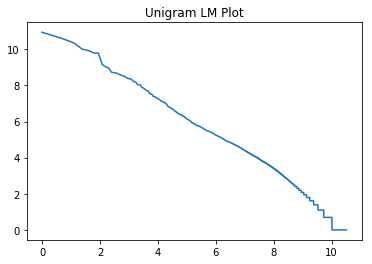

In [139]:
x=[np.log(i+1) for i in range(len(unigram_counts.most_common()))]
y=np.asarray(list(np.log(y[1]) for y in unigram_counts.most_common()))
plot(x,y,'Unigram LM Plot')

In [140]:
bigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),2, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in bigram_counts):
            bigram_counts[w]=1
        else:
            bigram_counts[w]+=1
bigram_LM= bigram_model(sents)

In [141]:
sorted_bigram_counts=sorted(bigram_counts.items(), key=operator.itemgetter(1),reverse=True)

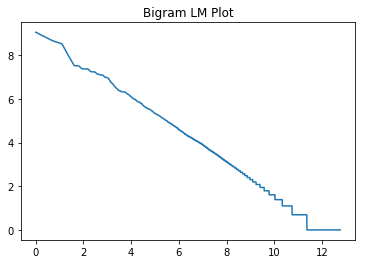

In [142]:
x=[np.log(i+1) for i in range(len(sorted_bigram_counts))]
y=np.asarray(list(np.log(y[1]) for y in sorted_bigram_counts[:]))
plot(x,y,'Bigram LM Plot')

In [143]:
trigram_counts={}
for sent in sents:
    for w in ngrams(sent.split(),3, pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if(w not in trigram_counts):
            trigram_counts[w]=1
        else:
            trigram_counts[w]+=1

trigram_LM= trigram_model(sents)

In [144]:
sorted_trigram_counts=sorted(trigram_counts.items(), key=operator.itemgetter(1),reverse=True)

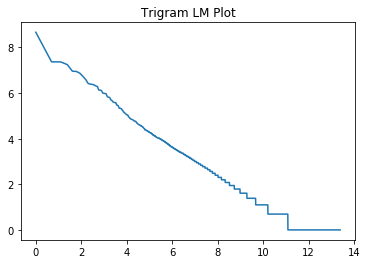

In [145]:
x=[np.log(i+1) for i in range(len(sorted_trigram_counts))]
y=np.asarray(list(np.log(y[1]) for y in sorted_trigram_counts))
plot(x,y,'Trigram LM Plot')

## Testing (without smoothing)

In [146]:
test_sents=get_test_sentences()
#test_sents=['it recommended that fulton legislators act to have these laws studied and revised to the end of modernizing and improving them ']

In [147]:
test_unigram_arr=[]
print('Unigram test probabilities: ')
print()
for sent in test_sents:
    try:
        p_val=np.sum([np.log(unigram_freq[word]) for word in sent.split()])
    except Exception as e:
        p_val=-np.inf
    test_unigram_arr.append(p_val)
    print('The sequence \"'+sent+' \" has unigram probablity of '+ str(p_val))


Unigram test probabilities: 

The sequence "he lived a good life  " has unigram probablity of -32.61637181331728
The sequence "the man was happy  " has unigram probablity of -23.897270970344053
The sequence "the person was good  " has unigram probablity of -23.326684213898012
The sequence "the girl was sad  " has unigram probablity of -27.222336320670067
The sequence "he won the war " has unigram probablity of -24.106951714822433


In [148]:
test_bigram_arr=[]
for sent in test_sents:
    p_val=0
    for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        if w1 in bigram_LM:
            try:
                p_val+=np.log(bigram_LM[w1][w2])
            except Exception as e:
                p_val=-np.inf
                break
        else:
            p_val=-np.inf
            break
    print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
    test_bigram_arr.append(p_val)

The sequence "he lived a good life " has bigram probablity of -26.88656843222555
The sequence "the man was happy " has bigram probablity of -22.06160121911623
The sequence "the person was good " has bigram probablity of -24.839981504247724
The sequence "the girl was sad " has bigram probablity of -inf
The sequence "he won the war" has bigram probablity of -20.079546963054263


In [149]:
test_trigram_arr=[]
print('Trigram test probabilities: ')
for sent in test_sents:
    p_val=0
    for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
        try:
            p_val+=np.log(trigram_LM[(w1,w2)][w3])
        except Exception as e:
            p_val=-np.inf
            break
    print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))
    
    test_trigram_arr.append(p_val)

Trigram test probabilities: 
The sequence "he lived a good life " has trigram probablity of -inf
The sequence "the man was happy " has trigram probablity of -inf
The sequence "the person was good " has trigram probablity of -inf
The sequence "the girl was sad " has trigram probablity of -inf
The sequence "he won the war" has trigram probablity of -16.519106408717104


## Laplace/ Additive Smoothing

In [150]:
k_list=[pow(10,i) for i in range(-4,1)]

In [151]:
test_bigram_arr=[]
num_unique_bigrams=len(bigram_counts.values())
for k in k_list:

    print('Bigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_bigram_model(w1,w2,bigram_counts,unigram_counts,k,num_unique_bigrams)

        print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 
The sequence "he lived a good life " has bigram probablity of -27.450457580648504
The sequence "the man was happy " has bigram probablity of -22.58165390931804
The sequence "the person was good " has bigram probablity of -25.12819840502108
The sequence "the girl was sad " has bigram probablity of -35.620729356365686
The sequence "he won the war" has bigram probablity of -20.456565445354194


Bigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 
The sequence "he lived a good life " has bigram probablity of -29.776496226080162
The sequence "the man was happy " has bigram probablity of -24.43511962952826
The sequence "the person was good " has bigram probablity of -26.623073590610694
The sequence "the girl was sad " has bigram probablity of -36.53254678037089
The sequence "he won the war" has bigram probablity of -22.22648806992158


Bigram test probabilities with Laplacian/ Additive

In [152]:
num_unique_trigrams=len(trigram_counts.values())
for k in k_list:
    test_trigram_arr=[]
    print('Trigram test probabilities with Laplacian/ Additive Smoothing with k as',k,': \n')
    for sent in test_sents:
        p_val=0
        for w1,w2,w3 in trigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=laplacian_trigram_model(w1,w2,w3,trigram_counts,bigram_counts,k,num_unique_trigrams)
        print('The sequence \"'+ sent +'\" has trigram probablity of '+ str(p_val))

        test_trigram_arr.append(p_val)
    print("\n")

Trigram test probabilities with Laplacian/ Additive Smoothing with k as 0.0001 : 

The sequence "he lived a good life " has trigram probablity of -52.46606168633371
The sequence "the man was happy " has trigram probablity of -38.76649747678443
The sequence "the person was good " has trigram probablity of -39.86328829743057
The sequence "the girl was sad " has trigram probablity of -43.39338538423813
The sequence "he won the war" has trigram probablity of -18.413719625045335


Trigram test probabilities with Laplacian/ Additive Smoothing with k as 0.001 : 

The sequence "he lived a good life " has trigram probablity of -55.70750795747099
The sequence "the man was happy " has trigram probablity of -42.47820888908575
The sequence "the person was good " has trigram probablity of -43.93749255001991
The sequence "the girl was sad " has trigram probablity of -47.960908316967114
The sequence "he won the war" has trigram probablity of -26.659171387525458


Trigram test probabilities with Laplac

## Interpolation Models

In [153]:
def interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts):
    num_unigrams=len(unigram_counts.values())
    if (w1 in unigram_counts):
        probability= Lambda*((bigram_counts.get((w1,w2),0))/(unigram_counts.get(w1,0))) +(1-Lambda)*(unigram_counts.get(w1,0)/num_unigrams)
    else:
        print(w1)
        return -np.inf
    if(probability==0):
        return -np.inf
    else:
        return np.log(probability)

In [154]:
test_bigram_arr=[]
lambda_list=[0.2, 0.5, 0.8]
num_unique_bigrams=len(bigram_counts.values())
for Lambda in lambda_list:

    print('Bigram test probabilities with Interpolation with lambda as',Lambda,': ')
    for sent in test_sents:
        p_val=0
        for w1,w2 in bigrams(sent.split(),pad_left=True,pad_right=True,left_pad_symbol='<s>',right_pad_symbol='</s>'):
            p_val+=interpolation_bigram(w1,w2,Lambda,bigram_counts,unigram_counts)

        print('The sequence \"'+ sent +'\" has bigram probablity of '+ str(p_val))
        test_bigram_arr.append(p_val)
    print("\n")

Bigram test probabilities with Interpolation with lambda as 0.2 : 
The sequence "he lived a good life " has bigram probablity of -15.87248011239857
The sequence "the man was happy " has bigram probablity of -9.448871116761818
The sequence "the person was good " has bigram probablity of -10.975486142101563
The sequence "the girl was sad " has bigram probablity of -10.753960661875333
The sequence "he won the war" has bigram probablity of -8.715318554854898


Bigram test probabilities with Interpolation with lambda as 0.5 : 
The sequence "he lived a good life " has bigram probablity of -16.262783895891527
The sequence "the man was happy " has bigram probablity of -9.965106482793885
The sequence "the person was good " has bigram probablity of -11.640314732890428
The sequence "the girl was sad " has bigram probablity of -10.563277185290215
The sequence "he won the war" has bigram probablity of -8.48946188317287


Bigram test probabilities with Interpolation with lambda as 0.8 : 
The sequenc